In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split
import datetime  as dt 

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [6]:
df = pd.read_csv('example_time_series.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    200 non-null    object 
 1   ts_1    200 non-null    float64
 2   ts_2    200 non-null    float64
 3   ts_3    200 non-null    float64
 4   ts_4    200 non-null    float64
 5   ts_5    200 non-null    float64
 6   ts_6    200 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.1+ KB


In [7]:
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6
Date,,,,,,
2020-01-05,0.422207,-0.334830,-0.194485,0.304119,0.335330,0.628650
2020-01-12,-0.455290,-0.343508,-0.649775,0.385431,0.253175,-0.062857
2020-01-19,0.914767,-0.080714,0.264993,0.987436,0.202251,0.474599
2020-01-26,0.562761,0.010582,0.827754,0.830760,0.137298,-0.591919
2020-02-02,-0.649239,-0.088101,0.178515,-0.827785,0.305798,-0.372528
...,...,...,...,...,...,...
2023-10-01,-0.180337,0.034521,-3.690399,0.698037,0.730687,-0.901562
2023-10-08,-0.607009,-0.126291,-4.297408,-1.720225,0.582334,0.515721
2023-10-15,0.616274,-0.242378,-3.681135,2.085681,0.703901,0.801864


<Axes: xlabel='Date'>

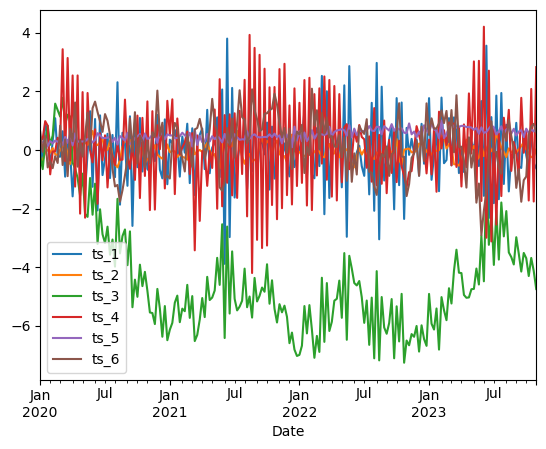

In [8]:
df.plot()

In [9]:
# Split the dataframe into 6 different time series
ts_1 = df['ts_1']
ts_2 = df['ts_2']
ts_3 = df['ts_3']
ts_4 = df['ts_4']
ts_5 = df['ts_5']
ts_6 = df['ts_6']



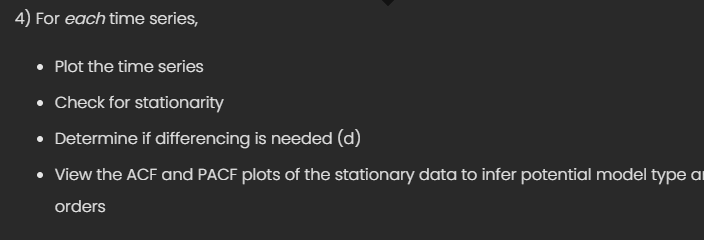

#  ts_1 

<Axes: xlabel='Date'>

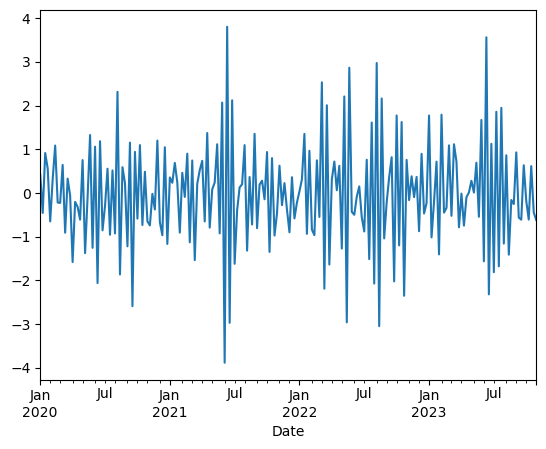

In [11]:
ts_1.plot()

In [13]:
# # is it stationary? 
get_adfuller_results(ts_1)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


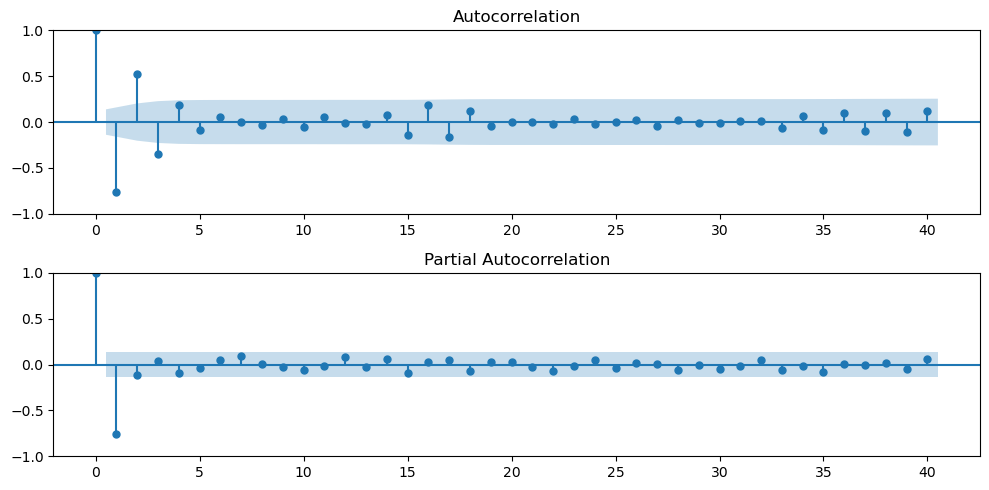

In [14]:
# Raw data is stationary, now plot ACF and PACF
plot_acf_pacf(ts_1);



* ACF trails off while PACF drops off.
* The last significant lag for PACF is 1
* We should try AR(1) = (1, 0, 0)

# ts_ 2 


<Axes: xlabel='Date'>

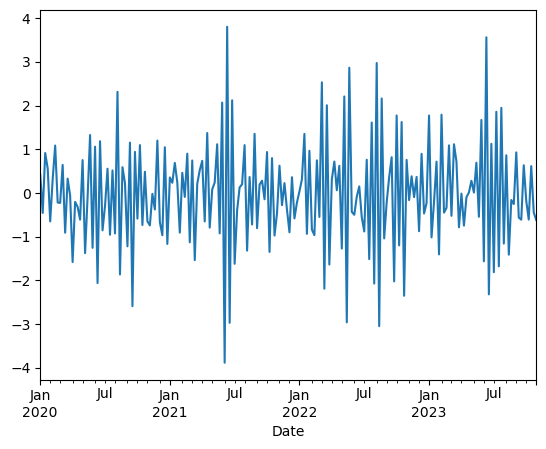

In [15]:
ts_1.plot()

In [17]:
# # is it stationary? 
get_adfuller_results(ts_2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-6.139526,5,194,0.0,0.05,True


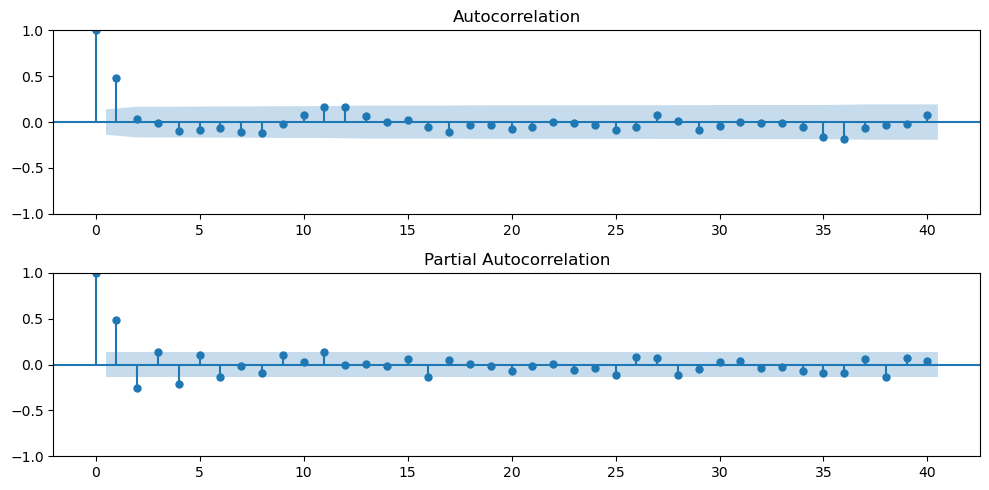

In [18]:
# Raw data is stationary, now plot ACF and PACF
plot_acf_pacf(ts_2);

* The ACF is a sure drop off with the value at lag 1 the last sig correlation
* We should try MA(1) = (0, 0, 1

# ts_3 

<Axes: xlabel='Date'>

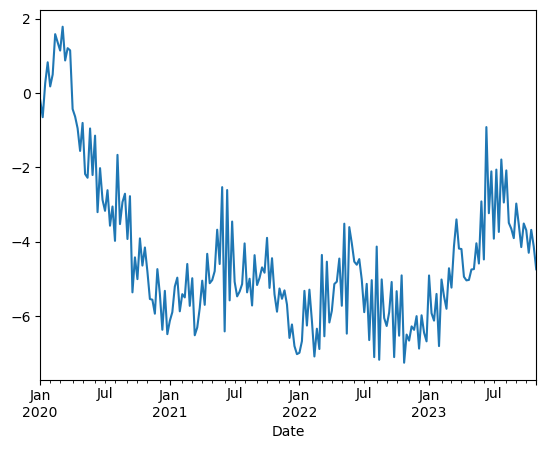

In [19]:
ts_3.plot()

In [20]:
get_adfuller_results(ts_3)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.366153,2,197,0.151518,0.05,False


In [21]:
# ndiffs 
d =ndiffs(ts_3)
print(f'd= {d}')

d= 1


In [23]:
 # raw data is not stationary, so we will apply differcing
ts_3_diff = ts_3.diff().dropna()
get_adfuller_results(ts_3_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.597695,1,197,0.0,0.05,True


In [24]:
get_adfuller_results(ts_3)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.366153,2,197,0.151518,0.05,False


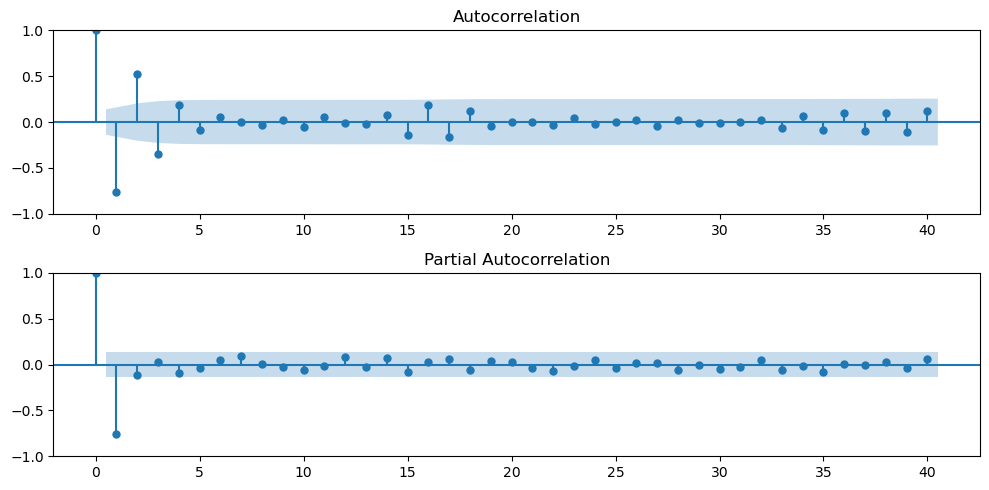

In [27]:
fig=plot_acf_pacf(ts_3_diff)

* ACF tails off, PACF drops off after 1 lag this is sig
* Try (1,1,0)

# ts_4 

<Axes: xlabel='Date'>

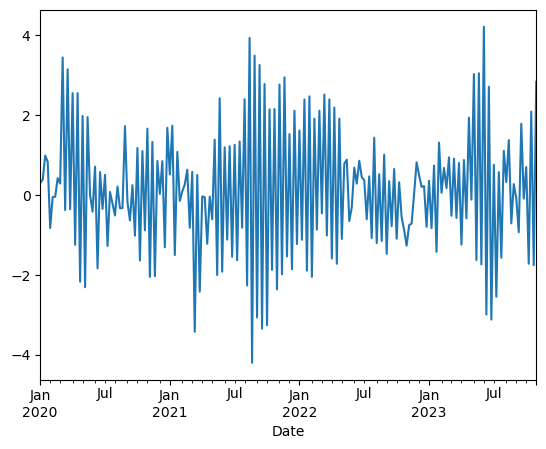

In [28]:
ts_4.plot()

In [29]:
get_adfuller_results(ts_4)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-6.825134,1,198,0.0,0.05,True


In [ ]:
plot_acf_pacf(ts_4)

* On PACF lag 2 the last significant lag
* Try AR(2) model = (2, 0, 0)

# ts_5 

<Axes: xlabel='Date'>

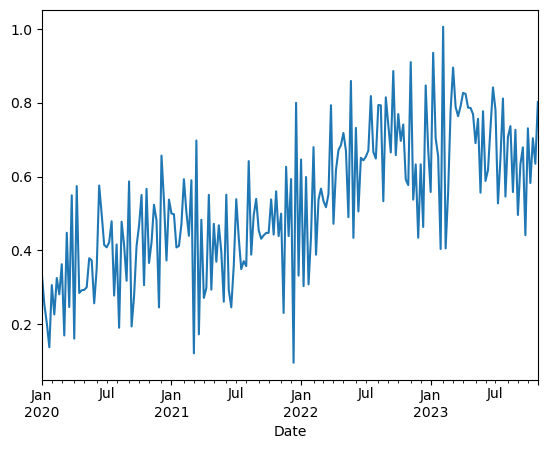

In [32]:
ts_5.plot()

In [34]:
get_adfuller_results(ts_5)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.085917,4,195,0.250215,0.05,False


In [35]:
ndiffs(ts_5)

1

In [36]:
ts_5_diff =  ts_5.diff().dropna()
get_adfuller_results(ts_5_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.465469,3,195,0.0,0.05,True


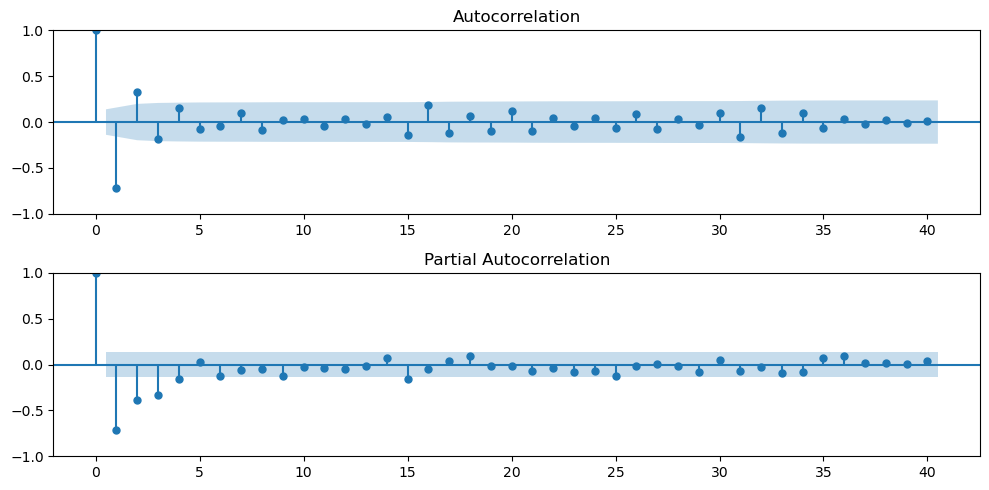

In [38]:
fig=plot_acf_pacf(ts_5_diff)

* Thus we can conclude that this is an ARMA model, BUT we cannot conclude p and q
* We will start with (1,1,1)
* We could then increase the p or q and see if the coefficient is sig or not when the model is fit

# ts_6

<Axes: xlabel='Date'>

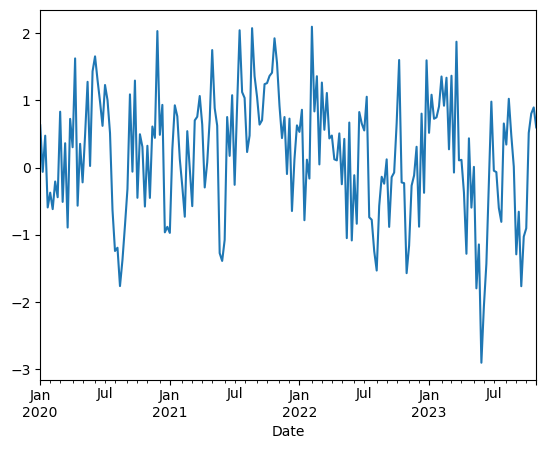

In [39]:
ts_6 .plot()

In [40]:
get_adfuller_results(ts_6)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.971288,9,190,0.001569,0.05,True


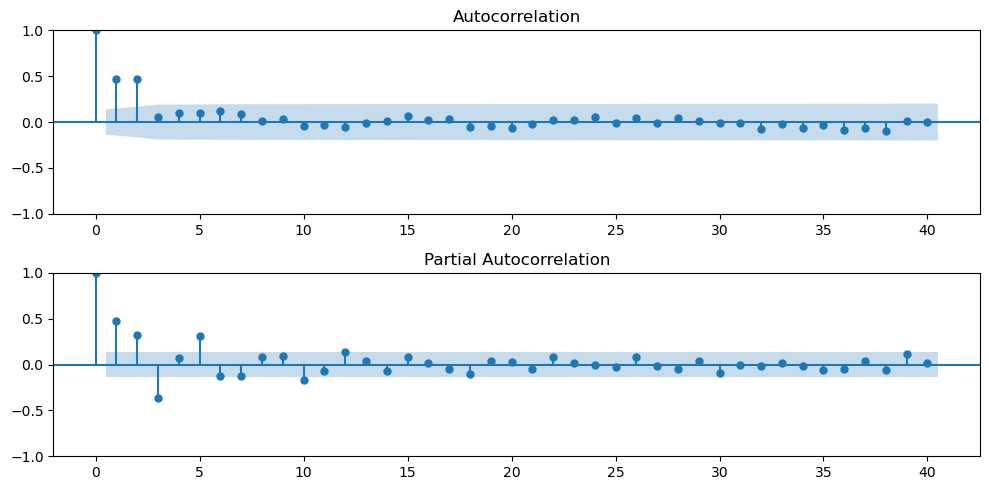

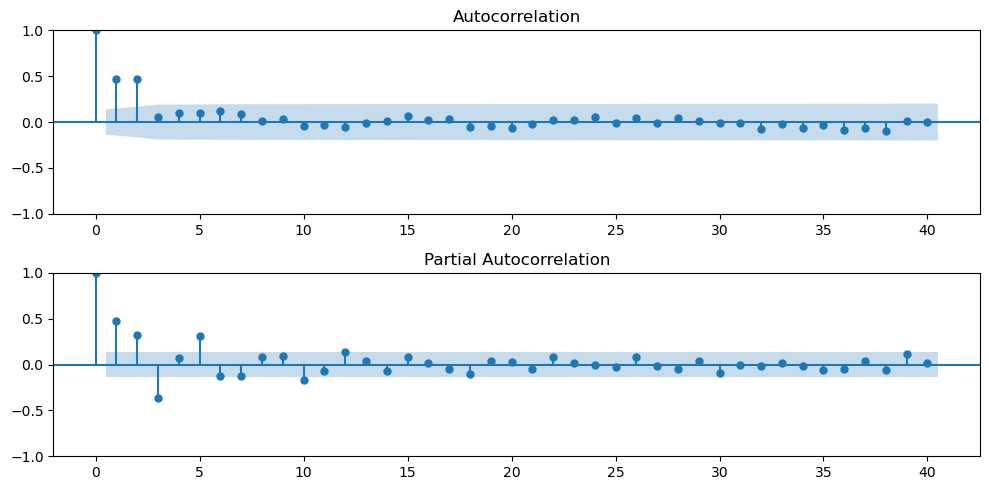

In [41]:
plot_acf_pacf(ts_6)